<a href="https://colab.research.google.com/github/zberis/DSPS_ZBeris/blob/main/HW10/Copy_of_higgsbosonSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import pandas as pd
import numpy as np
import pylab as pl
import os
import json
%pylab inline
pl.style.use("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/master/fbb.mplstyle")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

Populating the interactive namespace from numpy and matplotlib


In [2]:
#mount your google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Remember tasks are not completed if you do not comment on the results and include captions

# Task 1 : data ingestion

- Download the Higgs boson data from Kaggle (programmatically within the notebook)

see how I did it in the Titanic Trees notebook https://github.com/fedhere/DSPS_FBianco/blob/main/CodeDemos/titanictree.ipynb

find the correct API link here https://www.kaggle.com/c/higgs-boson/data. The command is `!kaggle competitions download......` (you may need to agree to the terms of condition of the higgs boson challenge on the kaggle webpage)


In [3]:
%cd /content/drive/MyDrive
!ls kaggle/kaggle.json

/content/drive/MyDrive
kaggle/kaggle.json


In [4]:
!chmod 600 kaggle/kaggle.json

In [5]:
envs = json.load(open("kaggle/kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [6]:
!kaggle datasets list


ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset    Global Earthquake-Tsunami Risk Assessment Dataset        16151  2025-10-01 16:35:53.273000          17641        607  1.0              
jaderz/hospital-beds-management                                 Hospital Beds Management                                 47583  2025-10-03 09:21:58.590000          14834        352  1.0              
umuttuygurr/e-commerce-customer-behavior-and-sales-analysis-tr  E-Commerce Customer Behavior & Sales Analysis -TR       138245  2025-10-29 13:58:22.810000           1714         37  1.0              


In [7]:
# i suggest you put the data in a folder inside of your dsps folder, which you shoudl already have
%cd dsps
!mkdir kagglehiggsbosonSearch
%cd kagglehiggsbosonSearch
!kaggle competitions download -c higgs-boson
!unzip higgs-boson.zip
!unzip training.zip

/content/drive/MyDrive/dsps
/content/drive/MyDrive/dsps/kagglehiggsbosonSearch
 94% 51.0M/54.3M [00:00<00:00, 266MB/s]
100% 54.3M/54.3M [00:00<00:00, 261MB/s]
Archive:  higgs-boson.zip
  inflating: HiggsBosonCompetition_AMSMetric_rev1.py  
  inflating: random_submission.zip   
  inflating: test.zip                
  inflating: training.zip            
Archive:  training.zip
  inflating: training.csv            


In [6]:
%cd /content/drive/MyDrive/dsps/kagglehiggsbosonSearch

/content/drive/MyDrive/dsps/kagglehiggsbosonSearch


In [63]:
#use the training dataset and make your own trainng test set later
higgsdata = pd.read_csv("training.csv")

# Task 2: data exploration

In [64]:
higgsdata.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [65]:
higgsdata.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.018636
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


do everything else you need to explore the data.... (I can think of 4 more things we have done together)

In [66]:
higgsdata.shape

(250000, 33)

In [67]:
higgsdata.tail()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
249995,349995,-999.000,71.989,36.548,5.042,-999.0,-999.0,-999.0,1.392,5.042,...,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,0.000,4.505083,b
249996,349996,-999.000,58.179,68.083,22.439,-999.0,-999.0,-999.0,2.585,22.439,...,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,-0.000,2.497259,b
249997,349997,105.457,60.526,75.839,39.757,-999.0,-999.0,-999.0,2.390,22.183,...,1,41.992,1.8,-0.166,-999.0,-999.0,-999.0,41.992,0.018636,s
249998,349998,94.951,19.362,68.812,13.504,-999.0,-999.0,-999.0,3.365,13.504,...,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,0.000,1.681611,b
249999,349999,-999.000,72.756,70.831,7.479,-999.0,-999.0,-999.0,2.025,7.479,...,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,0.000,1.877474,b


In [68]:
higgsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      250000 non-null  int64  
 1   DER_mass_MMC                 250000 non-null  float64
 2   DER_mass_transverse_met_lep  250000 non-null  float64
 3   DER_mass_vis                 250000 non-null  float64
 4   DER_pt_h                     250000 non-null  float64
 5   DER_deltaeta_jet_jet         250000 non-null  float64
 6   DER_mass_jet_jet             250000 non-null  float64
 7   DER_prodeta_jet_jet          250000 non-null  float64
 8   DER_deltar_tau_lep           250000 non-null  float64
 9   DER_pt_tot                   250000 non-null  float64
 10  DER_sum_pt                   250000 non-null  float64
 11  DER_pt_ratio_lep_tau         250000 non-null  float64
 12  DER_met_phi_centrality       250000 non-null  float64
 13 

In [69]:
higgsdata.columns

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label'],
      dtype='object')

In [70]:
higgsdata.dtypes

,0
EventId,int64
DER_mass_MMC,float64
DER_mass_transverse_met_lep,float64
DER_mass_vis,float64
DER_pt_h,float64
DER_deltaeta_jet_jet,float64
DER_mass_jet_jet,float64
DER_prodeta_jet_jet,float64
DER_deltar_tau_lep,float64
DER_pt_tot,float64


# Task 3: data preparation


- Read in the trainind data. Extract the target variables. Split the provided training data into a training and a test set.

The last 2 columns are what you want to predict: "weight" and "label".
Remove them from the input data (along any other variable you should remove) and create a separate variable `labels` and a separate variable `weights`, which will be your target variables for, respectively, classification and regression.



 you will use two target variables (you can read more about the data at https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf): find the corresponding columns of the DF and save them as labels and weights respectively

In [71]:
labels = higgsdata["Label"]
weights = higgsdata["Weight"]
higgsdata.drop(["EventId", "Label", "Weight"], axis=1, inplace=True)

In [72]:
labels # 's' stands for signal, 'b' for background. You want to find new particles, i.e. "signal"

,Label
0,s
1,b
2,b
3,b
4,b
...,...
249995,b
249996,b
249997,s
249998,b


In [73]:
weights # the weight of the particle

,Weight
0,0.002653
1,2.233584
2,2.347389
3,5.446378
4,6.245333
...,...
249995,4.505083
249996,2.497259
249997,0.018636
249998,1.681611


In [74]:
x = higgsdata.to_numpy()
y1 = labels.to_numpy()
y2 = weights.to_numpy()
print(y2)
print(y1)

[0.00265331 2.23358449 2.34738894 ... 0.01863612 1.68161144 1.87747381]
['s' 'b' 'b' ... 's' 'b' 'b']


use the "training.csv" file, but create your own train/test sets

In [75]:
train_x, test_x, train_y, test_y = train_test_split(x, y1, test_size=0.25, random_state=484, stratify=y1)
print("Shape of training features:", train_x.shape)
print("Shape of testing features:", test_x.shape)
print("Shape of training labels:", train_y.shape)
print("Shape of testing labels:", test_y.shape)

Shape of training features: (187500, 30)
Shape of testing features: (62500, 30)
Shape of training labels: (187500,)
Shape of testing labels: (62500,)


In [76]:
train_regress_x, test_regress_x, train_regress_y, test_regress_y = train_test_split(x, y2, test_size=0.25, random_state=484)
print("Shape of training features:", train_regress_x.shape)
print("Shape of testing features:", test_regress_x.shape)
print("Shape of training labels:", train_regress_y.shape)
print("Shape of testing labels:", test_regress_y.shape)

Shape of training features: (187500, 30)
Shape of testing features: (62500, 30)
Shape of training labels: (187500,)
Shape of testing labels: (62500,)


#Task 4: answer the question (you, not an AI...) why did I not ask you to scale the data like we did in the cluster models?

We did not scale the values because we are notcomparing the values from one column to another, and so they do not have to have the same scale.


# Task 5: tree-based classifications

Use a Random Forest and a Gradiend Boosted Tree Classifier model to predict the `label` of the particles, i.e. if a particle is `Signal` or `Background`. Get the score of each model on both the training and test set, compare them training and test results and comment on the result for each model (adjust the hyperparameters if you need to)


In [77]:
# Look at parameters used by our current forest
rf = RandomForestClassifier(random_state = 0)
print('Parameters currently in use:\n')
print(rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [78]:
#now control some hyperparameters
rf = RandomForestClassifier(
    n_estimators=100,
     max_depth=4,
    n_jobs=-1, random_state=484)

In [79]:
gbt =  GradientBoostingClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=484)


In [80]:
rf.fit(train_x, train_y)


RandomForestClassifier(max_depth=4, n_jobs=-1, random_state=484)

In [81]:
gbt.fit(train_x, train_y)

GradientBoostingClassifier(random_state=484)

# Task 6: model evaluation

calculate the  scores for the training and test sets and compare etc

In [17]:
print(f"the RF scores on the training set is {rf.score(train_x, train_y):.2%}, on the test set is {rf.score(test_x, test_y):.2%}")
print("this indicates to me that the model is not overfitting since the difference between the training set and test set is very small.")
print(f"the GBT scores on the training set is {gbt.score(train_x, train_y):.2%}, on the test set is {gbt.score(test_x, test_y):.2%}")
print("this indicates to me that the model is not overfitting since the difference between the training set and test set is very small.")


the RF scores on the training set is 80.99%, on the test set is 80.86%
this indicates to me that the model is not overfitting since the difference between the training set and test set is very small.
the GBT scores on the training set is 83.43%, on the test set is 83.32%
this indicates to me that the model is not overfitting since the difference between the training set and test set is very small.


**Comment** is your model performing well? is it .... overfitting?

The models are performing well and they are not overfitting as the difference between the training and test is very small.

- Produce a confusion matrix for each model and compare them






In [18]:
# I creaded this function (mostly copied from sklearn examples).
# You can use it to create the confusion matrix, make sure you pass appropriate label

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title='', labels=["P", "N"],
                          cmap=plt.cm.bone):
    """
    Plots a confusion matrix.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        normalize (bool, optional): If True, normalize the confusion matrix. Defaults to False.
        title (str, optional): Title of the plot. Defaults to ''.
        labels (list, optional): List of labels for the classes. Defaults to ["P", "N"].
        cmap (matplotlib.colors.Colormap, optional): Colormap for the plot. Defaults to plt.cm.bone.
    """
    if normalize:
          title = title + ' Normalized confusion matrix'
    else:
          title = title + ' Confusion matrix, without normalization'
    # Compute confusion matrix
    if normalize:
      cm = confusion_matrix(y_true, y_pred, normalize='all')
    else:
      cm = confusion_matrix(y_true, y_pred)
    # plot it
    fig, ax = plt.subplots(1, 1)
    fig.subplots_adjust()
    im = ax.imshow(np.rot90(cm), cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    # add an axes to the right of the main axes.
    plt.xticks([0, 1], labels=labels[::-1])

    plt.text(0,1, cm[0,0], ha='center', c="k" if cm[0,0] > 0.1 * cm.sum() else "w")
    plt.text(0,0, cm[0,1], ha='center', c="k" if cm[0,1] > 0.1 * cm.sum() else "w")
    plt.text(1,1, cm[1,0], ha='center', c="k" if cm[1,0] > 0.1 * cm.sum() else "w")
    plt.text(1,0, cm[1,1], ha='center', c="k" if cm[1,1] > 0.1 * cm.sum() else "w")
    plt.ylim(-0.5,1.5)
    plt.yticks([0,1], labels=labels)
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.title(title)
    cax = ax_divider.append_axes("right", size="10%", pad="2%")
    cb = plt.colorbar(im, cax=cax)

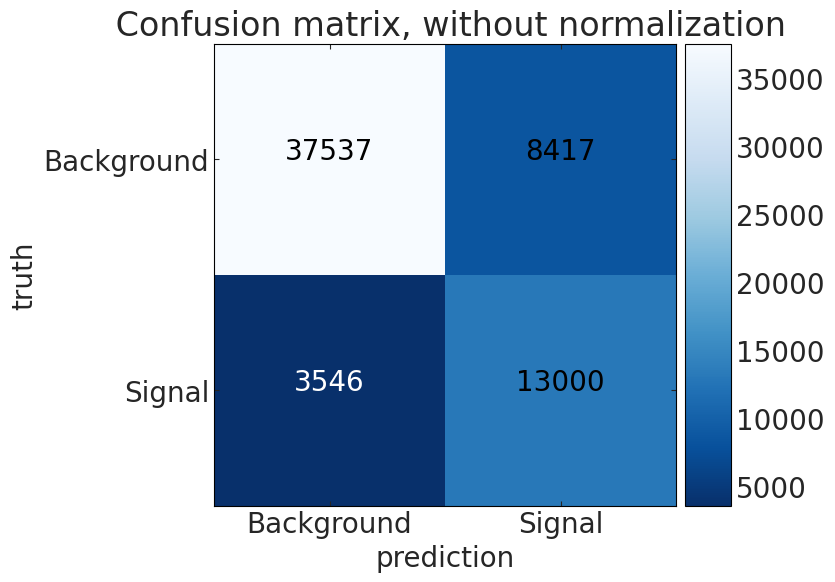

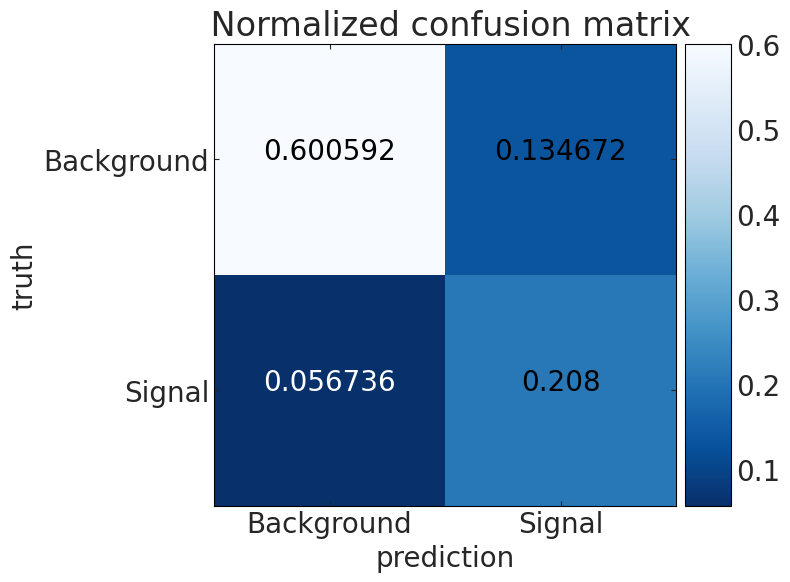

In [82]:
#for RF
plot_confusion_matrix(test_y, rf.predict(test_x), normalize=False, labels=["Signal", "Background"], cmap=plt.cm.Blues_r)
plot_confusion_matrix(test_y, rf.predict(test_x), normalize=True, labels=["Signal", "Background"], cmap=plt.cm.Blues_r)

These are two confusion matrices for the RF method. One is normalized, and the other is not. On the diagonanal we have where the prediction matched the truth, and on the off diagonal we have there the prediction did not match the truth. Signal means the particle is a higgs boson, background means it is not. We can see that the RF is very good at identifying background as background, but struggles significantly more with identifying signal as signal.

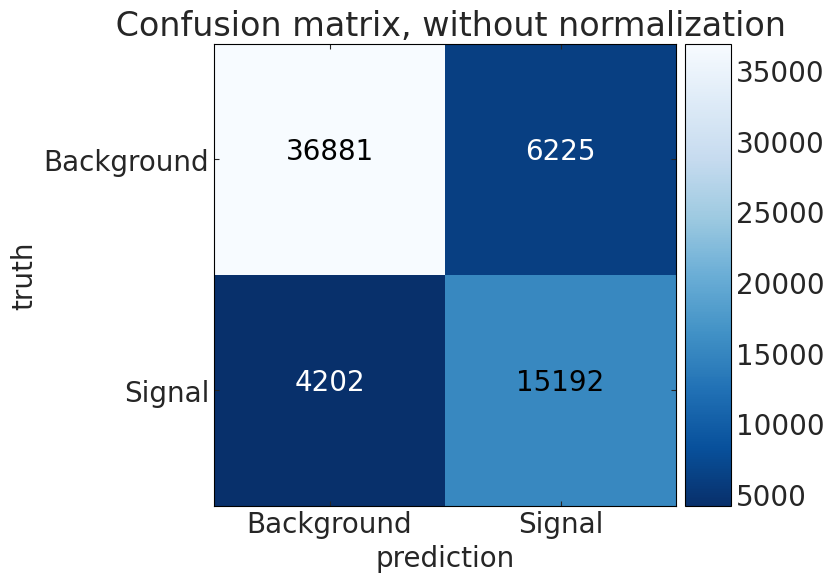

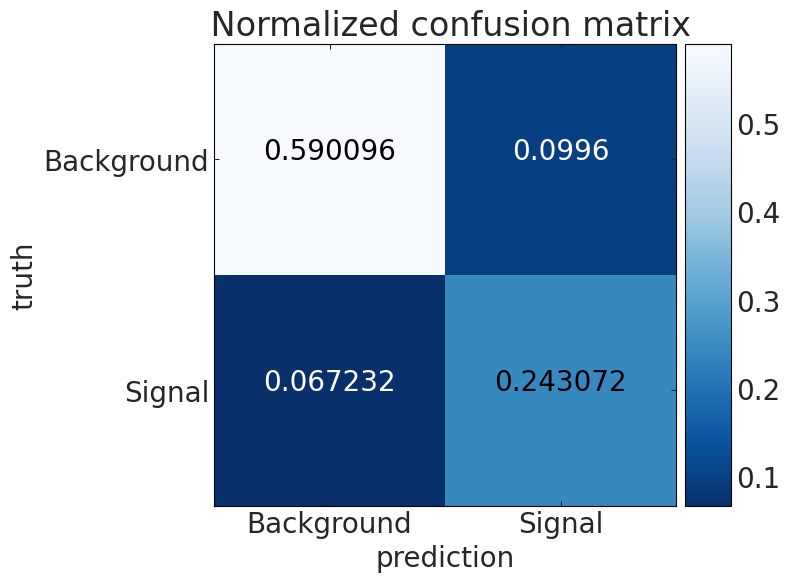

In [83]:
#do the same fo GBT, dont forget your captions!!
plot_confusion_matrix(test_y, gbt.predict(test_x), labels=["Signal", "Background"], normalize=False, cmap=plt.cm.Blues_r)
plot_confusion_matrix(test_y, gbt.predict(test_x), labels=["Signal", "Background"], normalize=True, cmap=plt.cm.Blues_r)

These are the confusion matrices made for the GBT. We have without normalization and with normalization. We can see that for GBT, it is again able to very well identify background as background, but once again is not able to identify signals as signals as well. But, this model does perform a bit better than RF.

Plot a simple ROC curve for the RF and GBT models  a d describe it in a caption.

In [21]:
#this will be passed to the ROC function
test_y.reshape(-1, 1).flatten() == "s"

array([False,  True, False, ..., False,  True, False])

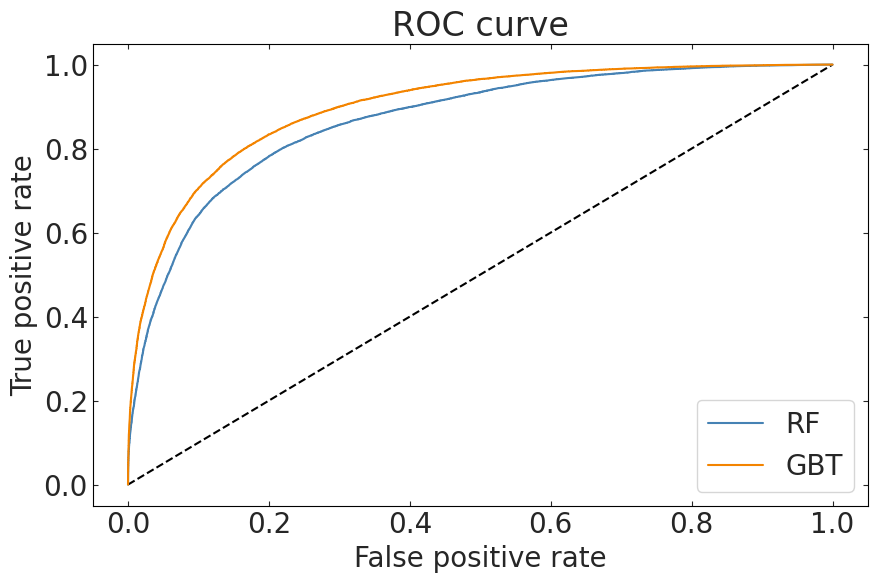

In [22]:
# The random forest model by itself
y_pred_grd_rfcat = rf.predict_proba(test_x)[:, 1]
y_pred_grd_gbtcat = gbt.predict_proba(test_x)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_rfcat)
fpr_gbt, tpr_gbt, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_gbtcat)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gbt, tpr_gbt, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


This is an ROC plot made for the RF model and the GBT model. We can see that both models perform relatively well, but GBT performs slightly better compared to RF. We know that these perform ok, because they near the upper left, but that they are not perfect because they do not go straight up and over but instead have a slight curve.

#Task 7 required for 661, EC for 461, tree-based regression


- Use a Random Forest and a Gradiend Boosted Tree Regressor model to predict the weight of the particles. Compare the model performance on training and test sets


In [23]:
rfR = RandomForestRegressor(max_depth=3, random_state=484)
rfR.fit(train_regress_x, train_regress_y)
gbtR = GradientBoostingRegressor(max_depth=3, random_state=484)
gbtR.fit(train_regress_x, train_regress_y)

GradientBoostingRegressor(random_state=484)

 Calculate the L2 and L1 loss functions for the fitted regression models (see slides for the definition) and discuss the results

In [24]:
def L1(y_true, y_pred):
  return np.mean(np.abs(y_true - y_pred))

def L2(y_true, y_pred):
  return np.mean((y_true - y_pred)**2)

In [25]:

print(f"L1 RF {L1(test_regress_y,  rfR.predict(test_regress_x)):.2f}, L2 RF {L2(test_regress_y, rfR.predict(test_regress_x)):.2f}")

L1 RF 1.01, L2 RF 1.84


In [26]:
print(f"L1 GBT {L1(test_regress_y,  gbtR.predict(test_regress_x)):.2f}, L2 GBT {L2(test_regress_y, gbtR.predict(test_regress_x)):.2f}")

L1 GBT 0.85, L2 GBT 1.37


**Discuss!**

#Task 8: Choose between feature importance and grid optimization (due for both 461 and 661)







# Task 8a: feature importance
Use the "Titanic notebook" as a guide for the feature importance analysis  https://github.com/fedhere/DSPS_FBianco/blob/main/Labs/DSPS_2025_titanictree.ipynb

- For the Random Forest classifier, find the 4 most important features based on the simple unoptimized model you created earlier on. Use the documentation to find out what they are. We have not talked abotu the physics of this problem at all but the Kaggle challenge description should provide enogh information for you to comment on this result is somewhat superficially.

You can use ```rf.feature_importance_``` on the trained model to extract the relative importance of each feature (a number from 0 to 1) and then choose the features that have the 4 highest numbers (the numpy function ```argsort()``` is helpful here!)

(your features may looks slightly different than mine)

In [27]:
# I asked gemini how to get the standard deviation
std_importances = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

print("Random Forest feature importance")
for f, fi, std in zip(higgsdata.columns, rf.feature_importances_, std_importances):
  print (f, fi.round(2), "+/-", (std.round(2)))

Random Forest feature importance
DER_mass_MMC 0.28 +/- 0.21
DER_mass_transverse_met_lep 0.18 +/- 0.18
DER_mass_vis 0.09 +/- 0.09
DER_pt_h 0.01 +/- 0.04
DER_deltaeta_jet_jet 0.05 +/- 0.08
DER_mass_jet_jet 0.02 +/- 0.05
DER_prodeta_jet_jet 0.0 +/- 0.01
DER_deltar_tau_lep 0.02 +/- 0.03
DER_pt_tot 0.0 +/- 0.01
DER_sum_pt 0.01 +/- 0.03
DER_pt_ratio_lep_tau 0.08 +/- 0.11
DER_met_phi_centrality 0.08 +/- 0.11
DER_lep_eta_centrality 0.03 +/- 0.05
PRI_tau_pt 0.08 +/- 0.11
PRI_tau_eta 0.0 +/- 0.0
PRI_tau_phi 0.0 +/- 0.0
PRI_lep_pt 0.0 +/- 0.02
PRI_lep_eta 0.0 +/- 0.0
PRI_lep_phi 0.0 +/- 0.0
PRI_met 0.02 +/- 0.03
PRI_met_phi 0.0 +/- 0.0
PRI_met_sumet 0.0 +/- 0.01
PRI_jet_num 0.0 +/- 0.02
PRI_jet_leading_pt 0.01 +/- 0.02
PRI_jet_leading_eta 0.0 +/- 0.01
PRI_jet_leading_phi 0.0 +/- 0.0
PRI_jet_subleading_pt 0.0 +/- 0.0
PRI_jet_subleading_eta 0.0 +/- 0.0
PRI_jet_subleading_phi 0.0 +/- 0.0
PRI_jet_all_pt 0.01 +/- 0.03


In [28]:
best_features_index = np.argsort(rf.feature_importances_)
best_features_index[-4:]

array([10,  2,  1,  0])

In [29]:
higgsdata.iloc[:, best_features_index[::-1]] #this sorts the data by feature

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,DER_deltaeta_jet_jet,DER_lep_eta_centrality,DER_mass_jet_jet,DER_deltar_tau_lep,...,PRI_met_sumet,PRI_lep_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_tau_eta,PRI_jet_subleading_eta,PRI_lep_phi,PRI_met_phi,PRI_jet_subleading_phi,PRI_tau_phi
0,138.470,51.655,97.827,1.582,1.396,32.638,0.91,0.2,124.711,3.064,...,258.733,2.273,0.444,46.062,1.017,1.24,-2.414,-0.277,-2.475,0.381
1,160.937,68.768,103.235,0.879,1.414,42.014,-999.00,-999.0,-999.000,3.473,...,164.546,0.501,1.158,-999.000,2.039,-999.00,0.103,-1.916,-999.000,-3.011
2,-999.000,162.172,125.953,3.776,1.414,32.154,-999.00,-999.0,-999.000,3.148,...,260.414,-0.953,-2.028,-999.000,-0.705,-999.00,1.052,-2.186,-999.000,-2.093
3,143.905,81.417,80.943,2.354,-1.285,22.647,-999.00,-999.0,-999.000,3.310,...,86.062,-0.522,-999.000,-999.000,-1.655,-999.00,-3.100,0.060,-999.000,0.010
4,175.864,16.915,134.805,1.056,-1.385,28.209,-999.00,-999.0,-999.000,3.891,...,53.131,0.798,-999.000,-999.000,-2.197,-999.00,1.569,-0.871,-999.000,-2.231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,-999.000,71.989,36.548,1.258,-1.414,24.754,-999.00,-999.0,-999.000,1.392,...,144.665,-0.950,-999.000,-999.000,-0.414,-999.00,0.380,2.859,-999.000,-0.905
249996,-999.000,58.179,68.083,1.162,-1.345,23.416,-999.00,-999.0,-999.000,2.585,...,80.408,0.308,-999.000,-999.000,-1.609,-999.00,1.042,-0.867,-999.000,2.776
249997,105.457,60.526,75.839,1.202,0.529,35.636,-999.00,-999.0,-999.000,2.390,...,198.907,0.381,-0.166,-999.000,-0.266,-999.00,0.851,-2.890,-999.000,-3.132
249998,94.951,19.362,68.812,0.999,1.414,27.944,-999.00,-999.0,-999.000,3.365,...,112.718,-0.874,-999.000,-999.000,-2.211,-999.00,-0.296,0.811,-999.000,2.792


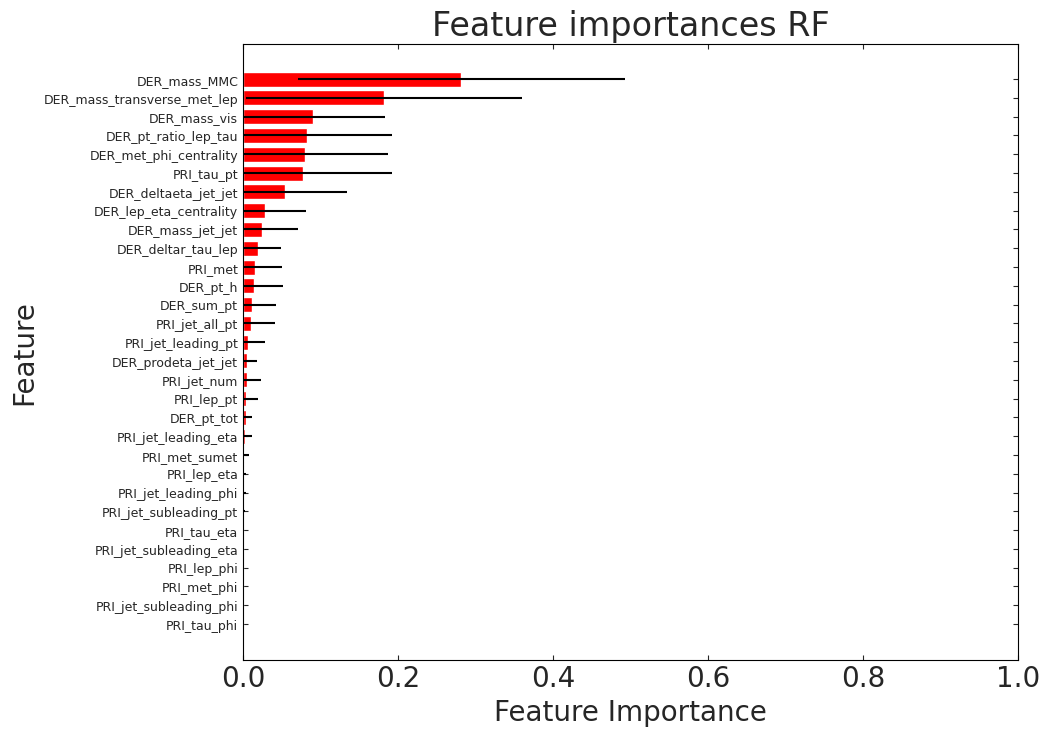

In [30]:
# I asked gemini to help me with plotting
plt.figure(figsize=(10, 8))
plt.title("Feature importances RF")


# Sort the feature importances and their standard deviations
sorted_importances = rf.feature_importances_[best_features_index]
sorted_std = std_importances[best_features_index]
sorted_feature_names = higgsdata.columns[best_features_index]


plt.barh(range(len(sorted_importances)), sorted_importances, color="r", xerr=sorted_std, align="center")
plt.yticks(range(len(sorted_importances)), sorted_feature_names, size = 9)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.xlim(0, 1)
plt.show()

This is a plot showing how important the different features are in the RF model that determine whether a data point is a signal or not. We can see that the 4 most important for the RF is the DER_mass_MMC, DER_mass_transverse_met_lep, DER_mass_vis, and DER_pt_ratio__lep_tau. It makes sense that the most important feature is the mass, as the higgs boson is a massive particle, compared to others.

In [31]:
print("GBT feature importance")
for f, fi in zip(higgsdata.columns, gbt.feature_importances_):
  print (f, fi.round(2))

GBT feature importance
DER_mass_MMC 0.4
DER_mass_transverse_met_lep 0.25
DER_mass_vis 0.11
DER_pt_h 0.01
DER_deltaeta_jet_jet 0.04
DER_mass_jet_jet 0.01
DER_prodeta_jet_jet 0.0
DER_deltar_tau_lep 0.04
DER_pt_tot 0.0
DER_sum_pt 0.0
DER_pt_ratio_lep_tau 0.01
DER_met_phi_centrality 0.03
DER_lep_eta_centrality 0.02
PRI_tau_pt 0.05
PRI_tau_eta 0.0
PRI_tau_phi 0.0
PRI_lep_pt 0.0
PRI_lep_eta 0.01
PRI_lep_phi 0.0
PRI_met 0.0
PRI_met_phi 0.0
PRI_met_sumet 0.0
PRI_jet_num 0.01
PRI_jet_leading_pt 0.0
PRI_jet_leading_eta 0.01
PRI_jet_leading_phi 0.0
PRI_jet_subleading_pt 0.0
PRI_jet_subleading_eta 0.0
PRI_jet_subleading_phi 0.0
PRI_jet_all_pt 0.0


In [32]:
best_features_index = np.argsort(gbt.feature_importances_)
best_features_index[-4:]

array([13,  2,  1,  0])

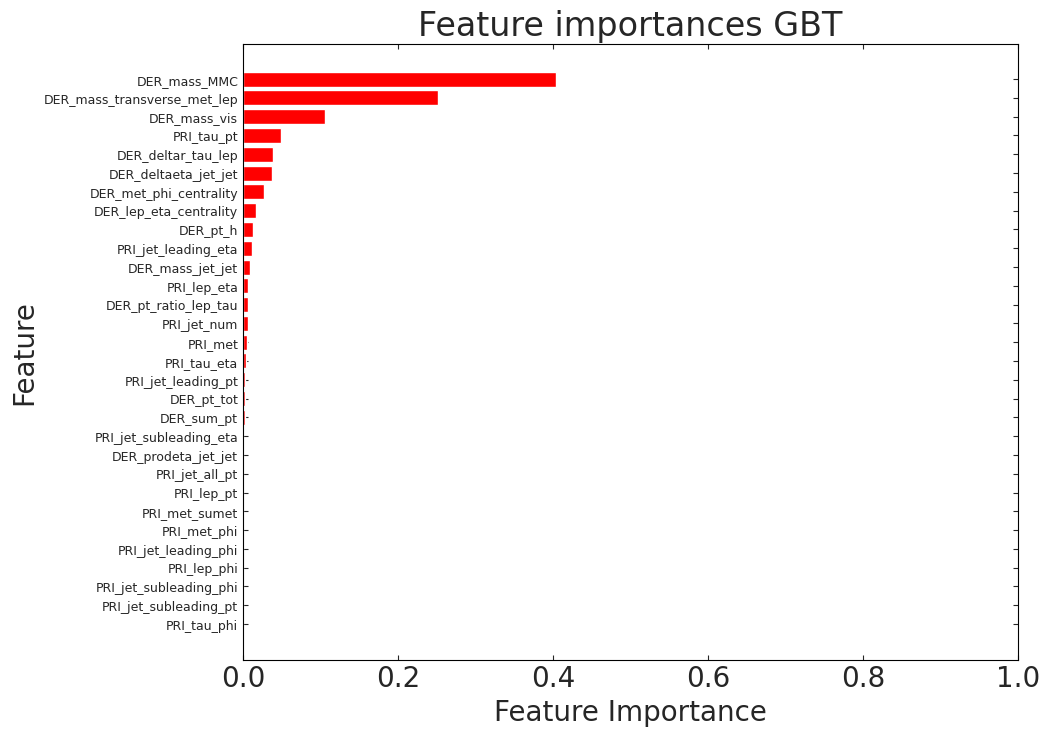

In [33]:
plt.figure(figsize=(10, 8))
plt.title("Feature importances GBT")


# Sort the feature importances and their standard deviations
sorted_importances = gbt.feature_importances_[best_features_index]
sorted_feature_names = higgsdata.columns[best_features_index]


plt.barh(range(len(sorted_importances)), sorted_importances, color="r", align="center")
plt.yticks(range(len(sorted_importances)), sorted_feature_names, size = 9)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.xlim(0, 1)
plt.show()

This is a plot showing how important the different features are in the GBT model that determine whether a data point is a signal or not. We can see that the 4 most important for the RF is the DER_mass_MMC, DER_mass_transverse_met_lep, DER_mass_vis, and PRI_tau_pt. We can see that both models have the same top 3 features. It again makes sense that the mass is the most important feature as the higgs boson is a massive particle comapred to others.  

# Task 8b: hyperparameters grid search
- Explore the parameter space with the sklearn module ```sklearn.model_selection.RandomizedSearchCV``` *fitting only those 4 features*

Follow this example to set up the parameter search. Set the estimators to 10 and 100, (the number of trees) and the max depth to 3, and 10, and None (let it be unconstrained). Set bootstrap to both True and False. Set the number of features to consider at every split to both "autp" and "sqrt". Use ```pprint``` like I did earlier in this notebook to print the parameters set

**this takes some computational time! so do not start this at the last minute!!**

In [43]:
from pprint import pprint
# choose your preferred values for the parameters you will test
random_grid = {'n_estimators': [10, 100],
               'max_depth': [3, 10, None],
               'bootstrap': [True, False],
               'max_features': [None, 'sqrt']}

In [44]:
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [3, 10, None],
 'max_features': [None, 'sqrt'],
 'n_estimators': [10, 100]}


 mine and your best features do not necessarily have to be the same because our models may be different (different parameters, different random seed etc)

In [54]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation,
# search across 18 different combinations
rf = RandomForestClassifier()
random_search = RandomizedSearchCV(estimator = rf, param_distributions=random_grid,
                                   n_iter=18, cv=3)

Note that this may take a long time! It took 1 hour for me to run this. Dont start at the last minute!!

In [55]:
random_search.fit(train_x[::5], train_y[::5])
# subselecting every 5th observation to reduce the computational time

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=18,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 10, None],
                                        'max_features': [None, 'sqrt'],
                                        'n_estimators': [10, 100]})

In [56]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=False)

In [57]:
for k in random_search.best_params_:
  print(k,random_search.best_params_[k])

n_estimators 100
max_features sqrt
max_depth None
bootstrap False


In [58]:
rf = RandomForestClassifier(**random_search.best_params_)
pprint(rf.get_params())

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [59]:
rf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=False)

In [60]:
print("Tuned RF  Parameters: {}".format(random_search.best_params_))
print("Best score is {}".format(rf.score(test_x, test_y)))


Tuned RF  Parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best score is 0.838752


In [61]:
df = pd.DataFrame(random_search.cv_results_) # this shows the result for the given parameters
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.529871,0.494807,0.022369,0.006240,10,None,3,False,"{'n_estimators': 10, 'max_features': None, 'ma...",0.78280,0.78624,0.79376,0.787600,0.004577,14
1,18.553028,0.344324,0.161593,0.022254,100,sqrt,10,False,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.82240,0.83192,0.83128,0.828533,0.004345,5
2,116.027769,1.866431,0.235472,0.025615,100,None,None,True,"{'n_estimators': 100, 'max_features': None, 'm...",0.82584,0.83264,0.83280,0.830427,0.003244,3
3,11.689807,0.402406,0.038685,0.007622,10,None,None,True,"{'n_estimators': 10, 'max_features': None, 'ma...",0.81072,0.81432,0.81448,0.813173,0.001736,10
4,17.659561,0.613878,0.036154,0.000537,10,None,None,False,"{'n_estimators': 10, 'max_features': None, 'ma...",0.76008,0.75792,0.76048,0.759493,0.001124,18
5,7.304598,0.451781,0.024560,0.000775,10,None,10,True,"{'n_estimators': 10, 'max_features': None, 'ma...",0.81816,0.82448,0.82512,0.822587,0.003141,7
6,18.376078,0.308671,0.264231,0.041060,100,sqrt,None,True,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.82744,0.83368,0.83312,0.831413,0.002819,2
7,2.931614,0.326321,0.042937,0.007705,10,sqrt,None,False,"{'n_estimators': 10, 'max_features': 'sqrt', '...",0.81584,0.81960,0.81336,0.816267,0.002565,8
8,28.557743,0.171850,0.291916,0.032177,100,sqrt,None,False,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.82864,0.83344,0.83536,0.832480,0.002826,1
9,22.881609,0.423298,0.074655,0.011975,100,None,3,True,"{'n_estimators': 100, 'max_features': None, 'm...",0.78560,0.78808,0.79440,0.789360,0.003705,12


Plot a simple  ROC curve for the RF model with the best parameters found in the previous step. Describe it. Compare it with the GBT model from before

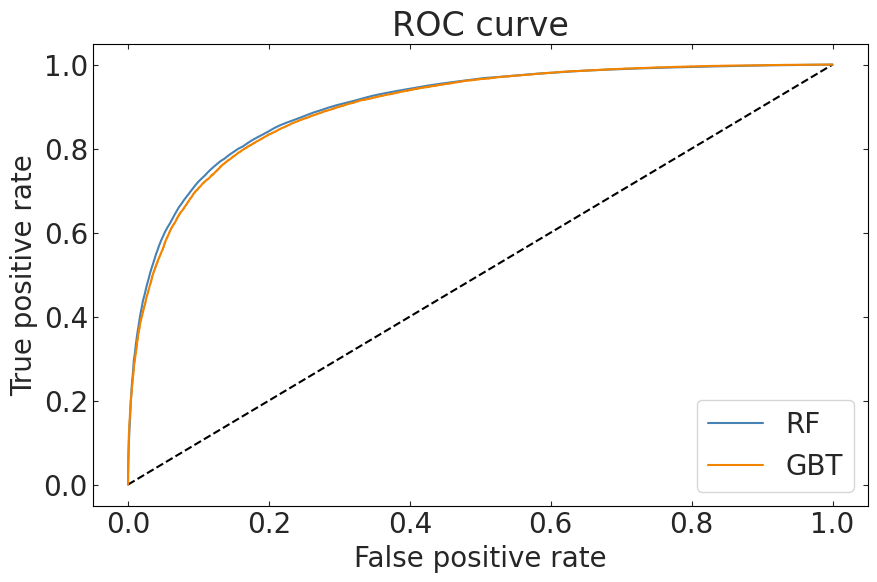

In [62]:
# The random forest model by itself
y_pred_grd_rfcat = rf.predict_proba(test_x)[:, 1]
y_pred_grd_gbtcat = gbt.predict_proba(test_x)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_rfcat)
fpr_gbt, tpr_gbt, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_gbtcat)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gbt, tpr_gbt, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

This is another ROC plot for the RF and GBT. We can see that after doing a grid search for RF, we have found the right parameters to make RF competitive with GBT.